In [1]:
# import things
import KenGP as gp
import numpy as np
import pandas as pd
import numpy.linalg as la
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons


In [2]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

In [3]:
def delayEmbed(X, Y,assignment,embInterval):
    
    tmplen = X.shape[1]

    tmp = np.zeros([sum(x) for x in zip(X.shape,(0,sum(assignment)))])
    tmp[:,:X.shape[1]] = X
    X = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            for _ in range(assignment[i]):
                newCol = X[:-embInterval*lag,i]
                X = X[embInterval*lag:]
                X[:, tmplen + newColInd] = newCol
                lag += 1
                newColInd += 1
    
    Y = Y[-X.shape[0]:]
    
    return (X, Y)

In [4]:
begin = 0
end = 50
step = 0.25
tlen = int((end-begin)/step)
trainToTest = 0.8 # between 0 and 1
t = np.arange(begin, end, step)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 3
t0 = np.array([1,1,10])# np.zeros(dim)
t0[0] += 0.1

In [5]:

# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
states = odeint(Rossler,t0,t)
# END STATIONARY SIMULATION

# FROM DATA
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()
print(states)
"""
# END FROM DATA


# NON STATIONARY VERSION
"""
rho = 0.2        # rho = 28.0
sigma = 0.2       # sigma = 10.0
beta = 5.7  # beta = 8.0 / 3.0

deltaP = 0.005
states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    states[i] = odeint(RosslerP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]
    sigma += deltaP

# END NON STATIONARY
"""

'\nrho = 0.2        # rho = 28.0\nsigma = 0.2       # sigma = 10.0\nbeta = 5.7  # beta = 8.0 / 3.0\n\ndeltaP = 0.005\nstates = np.zeros((tlen,3))\nstates[0] = t0\nfor i in range(1, tlen ):\n    states[i] = odeint(RosslerP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]\n    sigma += deltaP\n\n# END NON STATIONARY\n'

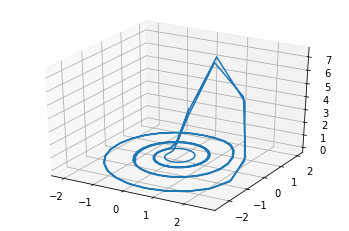

In [6]:
# Normalize, split data
states = (states - states.mean(0) ) / states.std(0) # normalize
testTrainSplit = int(states.shape[0] * trainToTest)

X = states[:-1,]
Y = states[1:,]

# Print Input
fig2 = plt.figure(2)
ax2 = fig2.gca(projection="3d")
if dim == 2:
    ax2 = plt.subplot()
    ax2.plot(X[:,0],X[:,1])
else:
    ax2.plot(X[:,0],X[:,1],X[:,2])
    
# Xt = np.column_stack((X[testTrainSplit:,], X[testTrainSplit-1:-1,1]))
Xt = X[testTrainSplit:,]
Yt = Y[testTrainSplit:,]
X = X[:testTrainSplit,]
Y = Y[:testTrainSplit,]


In [7]:
# GP setup
gp.setCovar("sqrexpf")
# gp.setPrior(1,"half-normal")
#gp.setPrior(2,"half-normal")
gp.setData(X,Y)
gp.setTimeDelayInterval(1)

assignment = [1,1,2]
gp.setDelayEmbedding(assignment)
gp.setPrior(4,"ARD")
gp.setPrior(5,"ARD")
embDim = 3

Xt, Yt = delayEmbed(X,Y,assignment,1)


Prior dict  {0: 'none', 1: 'none', 2: 'none', 3: 'none'}
Covariance function set to  sqrexpf
r =  7.947426622575653  versus approx  7.794228634059947
Data input success
r =  11.749229833169485  versus approx  11.905880899790658
Prior dict  {0: 'none', 1: 'none', 2: 'none', 3: 'none', 4: 'none', 5: 'none', 6: 'none', 7: 'none'}
New X Dimensions  (150, 7)
Prior dict  {0: 'none', 1: 'none', 2: 'none', 3: 'none', 4: 'ARD', 5: 'none', 6: 'none', 7: 'none'}
Prior dict  {0: 'none', 1: 'none', 2: 'none', 3: 'none', 4: 'ARD', 5: 'ARD', 6: 'none', 7: 'none'}


Gradient:  [-0.77301648  0.15742559 -0.60302026 -0.08241798 -0.03844952 -0.03818103
 -0.04589259 -0.04684297]
(1.0, -80.60881014603036) 88.3196467562003
Likelihood:  -2.430026534698097
Hp:  [0.45 0.62 0.45 0.45 0.45 0.45 0.45 0.45]  #  1
Gradient:  [-0.7842494  -0.09680525 -0.59487942 -0.11046705 -0.04413531 -0.04401144
 -0.0521607  -0.05377228]
(1.0, -81.90940052430187) 70.17217240432349
Likelihood:  7.320193952908596
Hp:  [0.39 0.56 0.39 0.39 0.39 0.39 0.39 0.39]  #  2
Gradient:  [-0.77358848 -0.07646647 -0.61406952 -0.08880751 -0.04758774 -0.04752046
 -0.05493032 -0.05661674]
(1.0, -114.79832583294717) 72.24894219236297
Likelihood:  22.754058689540763
Hp:  [0.318 0.488 0.318 0.318 0.318 0.318 0.318 0.318]  #  3
Gradient:  [-0.76431384 -0.05906218 -0.62881004 -0.06560645 -0.05230947 -0.05233697
 -0.05889255 -0.06071224]
(1.0, -161.69760511596198) 74.47091143954029
Likelihood:  45.12081824923253
Hp:  [0.2316 0.4016 0.2316 0.2316 0.2316 0.2316 0.2316 0.2316]  #  4
Gradient:  [-0.763885

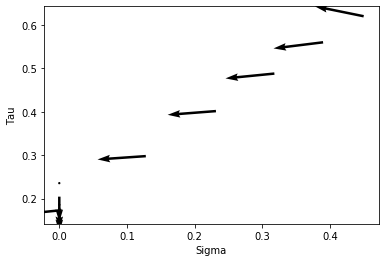

In [8]:
# 2.96355967e-05 3.10039090e+00 6.52724514e-03 9.60568331e-01
 #9.60568331e-01 9.60568331e-01
# optimize them parameters
gp.hyperParamOptimize(steps=20) # <<<< THIS IS EXPENSIVE

In [9]:
# One step predictions
diffTable = []
predictions = np.zeros((len(Xt),dim))
variances = np.zeros((len(Xt),1))
for i in range(len(Xt)):
    predTuple = gp.predict(Xt[i])
    variances[i] = predTuple[1]
    predictions[i] = predTuple[0] # list of one step prediction values for graphing
    
    diff = la.norm(Yt[i] - predictions[i]) # norm error for 1 step
    diffTable.append(diff)
# print("Predictions ", predictions)
# print("DiffTable ", diffTable)

diffTable = np.array(diffTable)

In [10]:
# feed forward prediction
n = 200 # num steps
feedForwardPrediction = np.zeros(((n,dim)))
feedForwardPrediction[0] = X[0]
for i in range(n-1):
    feedForwardPrediction[i+1] = gp.predict(feedForwardPrediction[i])[0]

ValueError: operands could not be broadcast together with shapes (7,) (3,) 

In [ ]:
fig0 = plt.figure(0)
if dim == 2:
    ax0 = plt.subplot()
    ax0.plot(Yt[:,0],Yt[:,1],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],'--r') # map of 1 step ahead predictions
else:
    ax0 = fig0.gca(projection="3d")
    ax0.plot(Yt[:,0],Yt[:,1],Yt[:,2],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],predictions[:,2],'--r') # map of 1 step ahead predictions
    # ax0.plot(feedForwardPrediction[:,0],feedForwardPrediction[:,1],feedForwardPrediction[:,2],'--g') # map of 50 step ahead prediction

fig1 = plt.figure(1)
plt.title("1 step error")
plt.hist(diffTable)

fig2 = plt.figure(2)
plt.hist(variances)
plt.title("GP Variance")

plt.show()

In [ ]:
# This doesn't work in Jupyter lol
fig3 = plt.figure(3)
sliderAx = plt.axes()
slider = Slider(sliderAx,"Tao", 0, 50, valinit=0, valstep=0.1)

fig4 = plt.figure(4)
paramAx = plt.axes()
paramButtons = RadioButtons(paramAx, ("rho","sigma","beta"), active = 0)

def update(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        rho = slider.val
    elif (paramButtons.value_selected == "sigma"):
        sigma = slider.val
    elif (paramButtons.value_selected == "beta"):
        beta = slider.val

    # Line Plot Update
    s = odeint(LorenzP,t0,t, args=(rho,sigma,beta))
    ax2.clear()
    ax2.plot(s[:,0], s[:,1], s[:,2])

    # Quiver Update
    mi = np.nanmin(s,axis=0)
    ma = np.nanmax(s,axis=0)
    st = abs(mi - ma) / 5
    print(st)

    x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
    u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
    ax2.quiver(x,y,z,u,v,w,length=5,normalize=True, color = "r", alpha = 0.25)
    
    fig2.canvas.draw()
    fig2.canvas.flush_events()

def update2(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        slider.set_val(rho)
    elif (paramButtons.value_selected == "sigma"):
        slider.set_val(sigma)
    elif (paramButtons.value_selected == "beta"):
        slider.set_val(beta)

slider.on_changed(update)
paramButtons.on_clicked(update2)

# Quiver Plot
fig2 = plt.figure(2)
ax2 = fig2.gca(projection="3d")


mi = np.nanmin(X,axis=0)
ma = np.nanmax(X,axis=0)
st = abs(mi - ma) / 5
print(st)

x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
ax2.quiver(x,y,z,u,v,w,length=st[0],normalize=True, color = "r", alpha=0.25)

plt.show()